# Transcription by Kaggler

- This notebook is for transcription.
- Purpose for doing this is to increase my ability to analyze data, modeling.

In [2]:
import pandas as pd
import numpy as np
import os
os.chdir("../../data/sf-crime")

train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

print(f"Shape of train data : {train.shape}")
print(f"Shape of test data : {test.shape}")

Shape of train data : (878049, 9)
Shape of test data : (884262, 7)


In [3]:
# 데이터를 로드하면 우선 Duplicated data가 있는지 확인하자!
train.duplicated().sum()

2323

In [4]:
import geopandas as gpd

In [5]:
from shapely.geometry import Point

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


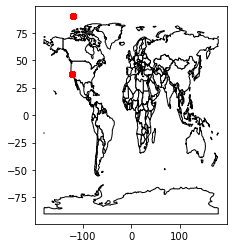

In [6]:
# geopandas를 이용해 경도, 위도값을 살펴봤을 때 미국 외에 잘못 기록된 곳이 있다.
import matplotlib.pyplot as plt
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(gdf,
                          geometry='Coordinates',
                          crs={'init':'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [7]:
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
train_gdf[['X','Y','Coordinates']].head()

,X,Y,Coordinates
0,-122.425892,37.774599,POINT (-122.42589 37.77460)
1,-122.425892,37.774599,POINT (-122.42589 37.77460)
2,-122.424363,37.800414,POINT (-122.42436 37.80041)
3,-122.426995,37.800873,POINT (-122.42700 37.80087)
4,-122.438738,37.771541,POINT (-122.43874 37.77154)


In [9]:
# 위도값이 40이 넘어가는 데이터 출력
print(train_gdf.loc[train_gdf.Y > 40].count()[0])
print()
# 그 중에 5개 데이터만 출력해보기
train_gdf.loc[train_gdf.Y > 40].sample(5)

67



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
675070,2005-10-18 20:00:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,PARK,NONE,TURK ST / STJOSEPHS AV,-120.5,90.0,POINT (-120.50000 90.00000)
839585,2003-07-08 19:22:00,WARRANTS,ENROUTE TO DEPARTMENT OF CORRECTIONS,Tuesday,SOUTHERN,"ARREST, BOOKED",1ST ST / BRANNAN ST,-120.5,90.0,POINT (-120.50000 90.00000)
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,POINT (-120.50000 90.00000)
767501,2004-06-24 00:03:00,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,Thursday,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.50000 90.00000)
767318,2004-06-24 13:00:00,OTHER OFFENSES,TRAFFIC VIOLATION,Thursday,MISSION,"ARREST, CITED",FLORIDA ST / ALAMEDA ST,-120.5,90.0,POINT (-120.50000 90.00000)


- 위에 처럼 위도가 벗어난 지역들은 해당 데이터의 District와 동일한 지역을 기준으로 그 지역들의 평균값으로 Coordinates를 대체


- SimpleImputer 클래스에서 몇 가지 달라진 점이 있습니다. missing_values 매개변수에 NaN을 지정할 때 문자열 ‘NaN’이 아니라 np.nan을 사용합니다. missing_values의 기본값이 np.nan입니다. strategy 매개변수에 mean, median, most_frequent 외에 constant가 추가되었습니다. strategy='constant'일 때 fill_value 매개변수에 채우려는 값을 지정합니다. SimpleImputer에는 axis 매개변수가 없습니다. 기본 동작 방식은 Imputer 클래스의 axis=0일 때와 같습니다. 행 방향으로 대체할 값을 계산하려면 FunctionTransformer를 사용하여 처리할 수 있습니다. 다음 코드는 입력 행렬의 행과 열을 바꾸어 대체할 값을 계산한 후 다시 변환된 행렬의 열과 행을 바꿉니다.

In [10]:
# 우선 중복 데이터 삭제
train.drop_duplicates(inplace=True)

In [11]:
from sklearn.impute import SimpleImputer
# 위,경도가 -120.5 , 90.0 으로 잘못 매핑된 데이터들을 na값으로 대체
# replace함수에 dict형태를 지정해줌으로써 '어떤 칼럼에 어떤값을' 지정 가능!
train.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)
test.replace({'X': -120.5, 'Y':90.0}, np.nan, inplace=True)

# 결측치를 대체하는 SimpleImputer할당
imp = SimpleImputer(strategy='mean')

# train, test 데이터에서 위,경도 결측치를 District에 맞는 위,경도로 대체
districts = train['PdDistrict'].unique()
for district in districts:
    train.loc[train['PdDistrict'] == district, ['X','Y']] = imp.fit_transform(train.loc[train['PdDistrict'] == district, ['X','Y']])
    test.loc[test['PdDistrict'] == district, ['X','Y']] = imp.fit_transform(test.loc[test['PdDistrict'] == district, ['X','Y']])
    
# 결측치 제대로 채운 다음 다시 위,경도 point 만들어내주는 함수 적용
train_gdf = create_gdf(train)

In [12]:
train['Dates'] = pd.to_datetime(train['Dates'])

In [13]:
train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23


In [14]:
# Date별로 그룹핑해서 얼마나 범죄가 발생했는지 count하기
# .iloc하는 이유는 어차피 그룹핑한 후 칼럼의 값들이 다 똑같기 때문에 첫번째 칼럼값만 갖고옴
data = train.groupby('Date').count().iloc[:,0]
data.head()

Date
2003-01-06    400
2003-01-07    417
2003-01-08    523
2003-01-09    416
2003-01-10    397
Name: Dates, dtype: int64

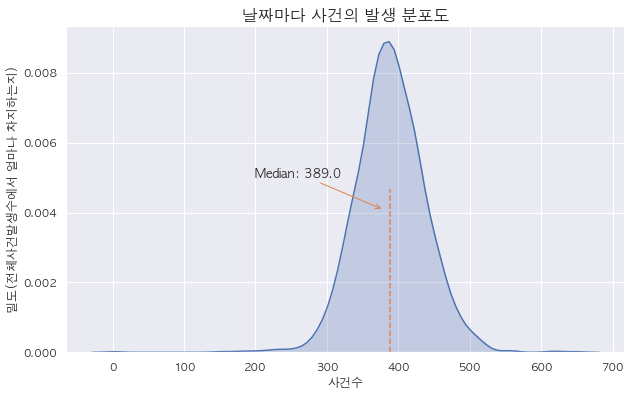

In [15]:
import seaborn as sns
sns.set(font='AppleGothic')

col = sns.color_palette()
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, shade=True)
# Per Date 범죄 발생건수 중앙값을 line으로 표시하는 방법
plt.axvline(x=data.median(), ymax=0.5,
           linestyle='--', color=col[1])
# 
plt.annotate(
    'Median: '+str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1],
                   shrinkB=10))
plt.title('날짜마다 사건의 발생 분포도', fontdict={'fontsize':16})
plt.xlabel('사건수')
plt.ylabel('밀도(전체사건발생수에서 얼마나 차지하는지)')
plt.legend().remove()
plt.show()

# 날짜(월요일~금요일)에 따른 사건의 빈도수의 표준편차가 크지 않다.
# 따라서 예측하는 데 있어서 날짜가 중요한 역할을 할 변수이진 않을 것이다.

In [16]:
import urllib.request
import re
import zipfile
# shutil : 고수준의 파일 복사, 삭제 지원하는 함수
import shutil

In [17]:
# url에 request요청해서 샌프란시스코 지역의 shapefile을 다운로드하기
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'

with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    # response로 url에 접근하고 out_file로 zip file에 byte형식으로 쓰기
    shutil.copyfileobj(response, out_file)

In [18]:
# zip file을 unzip하기
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')

In [19]:
# unzip한 파일 디렉토리가서 .shp 들어있는 파일 
for filename in os.listdir('./pd_data/'):
    # 정규표현식 의미 
    # .+ : 줄바꿈을 제외한 모든 문자가 한번 이상 반복되는 패턴
    # \. : 문자열 '.'으로 인식하도록 \붙여줌
    # shp : 해당 문자열 => 즉 .shp가 들어있는 문자열을 매칭하는 것
    # re.match함수는 아무것도 반환 안해줌.. 그래서 반환해주는 걸 쓰려면 search함수 사용
    if re.match('.+\.shp', filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        # 파일 하나니까 그만 찾도록 break
        break

In [20]:
# crs는 geopandas의 좌표꼐를 의미
# epsg:0000은 숫자에따라 구글지도/bing지도/야후지도/OSM등에서 사용중인 좌표계
pd_districts.crs = {'init':'epsg:4326'}

In [21]:
# pd_districts와 train의 공통 칼럼인 district를 기준으로해서 merge
# iloc안에 column인자에다가 리스트 한번 더 씌워서 데이터프레임형태로 반환
pd_districts = pd_districts.merge(train.groupby('PdDistrict').count().iloc[:,[0]].rename(columns={'Dates':'Incidents'}),
                  how='inner', left_on='district',
                  right_index=True, suffixes=('_x', '_y'))
# suffix : 중복되는 칼럼 구분하기 위해서 접두사 붙여주는 역할
pd_districts.head()

,company,district,shape_area,shape_le_1,shape_leng,geometry,Incidents
0,B,SOUTHERN,9.134414e+07,100231.353916,87550.275142,"MULTIPOLYGON (((-122.39186 37.79425, -122.3917...",156528
1,C,BAYVIEW,2.013846e+08,144143.480351,163013.798332,"POLYGON ((-122.38098 37.76480, -122.38103 37.7...",89098
2,D,MISSION,8.062384e+07,40518.834235,40152.783389,"POLYGON ((-122.40954 37.76932, -122.40862 37.7...",119723
3,E,NORTHERN,8.278169e+07,50608.310321,56493.858208,"POLYGON ((-122.43379 37.80793, -122.43375 37.8...",105105
4,J,TENDERLOIN,1.107215e+07,18796.784185,12424.268969,"POLYGON ((-122.40217 37.78626, -122.41718 37.7...",81642


In [22]:
# 다시 epsg형태 다른형태로 바꿔주기(좌표계 변환해주는 함수 to_crs())
pd_districts = pd_districts.to_crs({'init':'epsg:3857'})

In [23]:
# 모든 구역에 대해서 per day 발생한 사건 개수 계산
# shape의 행개수를 사건이 발생한 day개수로 할당
train_days = train.groupby('Date').count().shape[0]
# 구역별 발생한 모든 사건의 개수를 전체 사건이 발생한 개수로 나누기
# 즉, 구역별 발생한 사건이 전체 사건의 얼마나 비율을 차지하는지 보기 위함
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

In [24]:
pd_districts.rename(columns={'inc_per_day':'inc_per_district'},
                   inplace=True)

In [25]:
pd_districts.head()

,company,district,shape_area,shape_le_1,shape_leng,geometry,Incidents,inc_per_district
0,B,SOUTHERN,9.134414e+07,100231.353916,87550.275142,"MULTIPOLYGON (((-13624599.687 4550400.424, -13...",156528,69.598933
1,C,BAYVIEW,2.013846e+08,144143.480351,163013.798332,"POLYGON ((-13623388.690 4546253.046, -13623393...",89098,39.616719
2,D,MISSION,8.062384e+07,40518.834235,40152.783389,"POLYGON ((-13626567.569 4546889.202, -13626465...",119723,53.233882
3,E,NORTHERN,8.278169e+07,50608.310321,56493.858208,"POLYGON ((-13629267.400 4552328.198, -13629262...",105105,46.734104
4,J,TENDERLOIN,1.107215e+07,18796.784185,12424.268969,"POLYGON ((-13625747.385 4549275.384, -13627417...",81642,36.301467


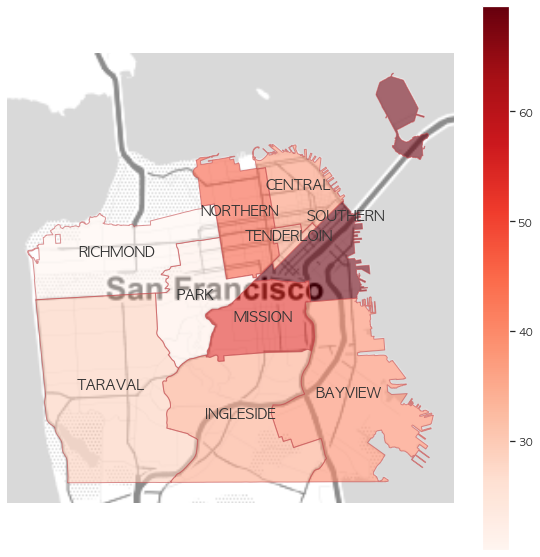

In [26]:
import contextily as ctx
#구역별 사건발생 수 시각화하기 
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(10,10))
pd_districts.plot(
    column='inc_per_district',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)
# 지도의 타일 배경 추가하는 함수 정의
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax,
                                    zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))
# 배경 추가하기
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# 구역 이름 추가하기
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
        pd_districts.loc[index].geometry.centroid.y),
        color='#353535', fontsize='large', fontweight='heavy',
        horizontalalignment='center'
    )
ax.set_axis_off()
plt.show()

In [27]:
crimes = train['Category'].unique().tolist()
crimes.remove('TREA')

In [28]:
pd_districts = pd_districts.to_crs({'init':'epsg:4326'})
sf_land = pd_districts.unary_union

In [29]:
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land),crs={'init':'epsg:4326'})
sf_land = sf_land.rename(columns={0:'geometry'}).set_geometry('geometry')

In [ ]:
import geoplot as gplt
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True,
                      figsize=(12,12))
# np.random.choice(a, size=, replace=, p=)
# a : 데이터, size : 샘플숫자(정수), replace:True면 복원추출가능, p:베열(각 데이터가 선택될 수 있는확률)
for i, crime in enumerate(np.random.choice(crimes, size=9, replace=False)):
    data = train_gdf.loc[train_gdf['Category'] == crime]
    ax = fig.add_subplot(3, 3 ,i+1)
    gplt.kdeplot(data, shade=True, shade_lowest=False,
                clip=sf_land.geometry, cmap='Reds', ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime)
    
plt.suptitle('Geographic Density of Different Crimes')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()